# Exploratory data analisis of METACRITIC Dataset

#### Libraries used

In [372]:
from io import StringIO
import json
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import seaborn as sns
import sys
sys.path.append('../dbconfig/')
from dbconfig import configuration

In [373]:
params = configuration()

conn = psycopg2.connect(**params)
cursor = conn.cursor()
print("Opened database successfully")

Reading configuration from database.ini
Opened database successfully


## Bring the dataset from the csv file

In [374]:
sys.path.append('../data/')
games_data = pd.read_csv('../data/games_clean.csv')


games_data.head()

,title,release_date,developer,publisher,genres,product_rating,user_score,user_ratings_count,platforms_info
0,Ziggurat (2012),2/17/2012,Action Button Entertainment,Freshuu Inc.,Action,NaN,6.9,14.0,"[{'Platform': 'iOS (iPhone/iPad)', 'Platform M..."
1,4X4 EVO 2,11/15/2001,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,NaN,NaN,"[{'Platform': 'Xbox', 'Platform Metascore': '5..."
2,MotoGP 2 (2001),1/22/2002,Namco,Namco,Auto Racing Sim,Rated E For Everyone,5.8,NaN,"[{'Platform': 'PlayStation 2', 'Platform Metas..."
3,Gothic 3,11/14/2006,Piranha Bytes,Aspyr,Western RPG,Rated T For Teen,7.5,832.0,"[{'Platform': 'PC', 'Platform Metascore': '63'..."
4,Siege Survival: Gloria Victis,5/18/2021,FishTankStudio,Black Eye Games,RPG,NaN,6.5,10.0,"[{'Platform': 'PC', 'Platform Metascore': '69'..."


# Description

In [375]:
games_data.describe()

,user_score,user_ratings_count
count,11714.000000,11299.000000
mean,6.894852,245.642977
std,1.392213,1847.895353
min,0.300000,5.000000
25%,6.200000,14.000000
50%,7.200000,34.000000
75%,7.900000,111.000000
max,10.000000,163419.000000


This information is so strange for our data set because we know that there are some columns that are numeric, but the information here says that there are none.

# Data type

In [376]:
games_data.dtypes

title                  object
release_date           object
developer              object
publisher              object
genres                 object
product_rating         object
user_score            float64
user_ratings_count    float64
platforms_info         object
dtype: object

Here we can look at some data types are not correctly, for example, release_date should be a 'datetime' data type but is an object, or user_score should be a float but is an object too.

# General information of the data

In [377]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14055 entries, 0 to 14054
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               14034 non-null  object 
 1   release_date        13991 non-null  object 
 2   developer           13917 non-null  object 
 3   publisher           13917 non-null  object 
 4   genres              14034 non-null  object 
 5   product_rating      11005 non-null  object 
 6   user_score          11714 non-null  float64
 7   user_ratings_count  11299 non-null  float64
 8   platforms_info      14055 non-null  object 
dtypes: float64(2), object(7)
memory usage: 988.4+ KB


In [378]:
count_empty = games_data.apply(lambda x: x.value_counts().get('', 0))

print(count_empty)

title                 0
release_date          0
developer             0
publisher             0
genres                0
product_rating        0
user_score            0
user_ratings_count    0
platforms_info        0
dtype: int64


Here we noticed that the dataset strangely has not null-values, but what happens is that in the insertion of the data we inserted all the columns in VARCHAR (strings) because it was causing us problems with the float and the integers type of data. Also the null-values did convert too in empties strings, like this: ''. So we convert this empty strings in null-values

In [379]:
games_data.replace('', pd.NA, inplace = True)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14055 entries, 0 to 14054
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               14034 non-null  object 
 1   release_date        13991 non-null  object 
 2   developer           13917 non-null  object 
 3   publisher           13917 non-null  object 
 4   genres              14034 non-null  object 
 5   product_rating      11005 non-null  object 
 6   user_score          11714 non-null  float64
 7   user_ratings_count  11299 non-null  float64
 8   platforms_info      14055 non-null  object 
dtypes: float64(2), object(7)
memory usage: 988.4+ KB


### Null values

In [380]:
null_report = games_data.isnull().sum()

null_report

title                   21
release_date            64
developer              138
publisher              138
genres                  21
product_rating        3050
user_score            2341
user_ratings_count    2756
platforms_info           0
dtype: int64

Now we have a real information about the null values, but actually we don't need a game information without title because we don't know what the game is, so we drop these null values.

# Convert data

### In this case, we convert the 'release_date' column from object to datetime

In [381]:
games_data['release_date'] = pd.to_datetime(games_data['release_date'], format='%m/%d/%Y', errors='coerce')

### now we convert the columns that should be integers or floats: 'user_score' and 'user_ratings_count'

In [382]:
games_data['user_ratings_count'] = pd.to_numeric(games_data['user_ratings_count'], errors='coerce').fillna(0).astype(int)
games_data['user_score'] = pd.to_numeric(games_data['user_score'], errors='coerce').fillna(0).astype(float)

We noticed that there are a few games without the data 'release_date', we do not drop these nulls because there is a lot of information in each row and we do not want to drop because a miss data.

In [383]:
def extract_first_platform_name(json_str):
    if json_str == 'Platforms Info' or json_str == '':
        return None
    try:
        # Load the string as JSON
        json_data = json.loads(json_str.replace("'", '"'))
        # Extract the first platform name only
        if json_data:
            first_platform_name = json_data[0]['Platform']
            return first_platform_name
    except json.JSONDecodeError as e:
        return None

# Apply the modified function to 'platforms_info' column
games_data['platforms'] = games_data['platforms_info'].apply(extract_first_platform_name)

# Display the result to check
print(games_data[['title', 'platforms']])

                                                   title          platforms
0                                        Ziggurat (2012)  iOS (iPhone/iPad)
1                                              4X4 EVO 2               Xbox
2                                        MotoGP 2 (2001)      PlayStation 2
3                                               Gothic 3                 PC
4                          Siege Survival: Gloria Victis                 PC
...                                                  ...                ...
14050                    Dragon Age: Origins - Awakening      PlayStation 3
14051                                      Lover Pretend    Nintendo Switch
14052                             Alice: Madness Returns                 PC
14053                                     Concrete Genie      PlayStation 4
14054  Lemony Snicket's A Series of Unfortunate Event...   Game Boy Advance

[14055 rows x 2 columns]


In [384]:
games_data.head()

,title,release_date,developer,publisher,genres,product_rating,user_score,user_ratings_count,platforms_info,platforms
0,Ziggurat (2012),2012-02-17,Action Button Entertainment,Freshuu Inc.,Action,NaN,6.9,14,"[{'Platform': 'iOS (iPhone/iPad)', 'Platform M...",iOS (iPhone/iPad)
1,4X4 EVO 2,2001-11-15,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,0.0,0,"[{'Platform': 'Xbox', 'Platform Metascore': '5...",Xbox
2,MotoGP 2 (2001),2002-01-22,Namco,Namco,Auto Racing Sim,Rated E For Everyone,5.8,0,"[{'Platform': 'PlayStation 2', 'Platform Metas...",PlayStation 2
3,Gothic 3,2006-11-14,Piranha Bytes,Aspyr,Western RPG,Rated T For Teen,7.5,832,"[{'Platform': 'PC', 'Platform Metascore': '63'...",PC
4,Siege Survival: Gloria Victis,2021-05-18,FishTankStudio,Black Eye Games,RPG,NaN,6.5,10,"[{'Platform': 'PC', 'Platform Metascore': '69'...",PC


In [385]:
games_data.drop(columns=['platforms_info'], inplace=True)

In [386]:
# Renaming the columns
games_data.rename(columns={
    'product_rating' : 'rating',
    'release_date' : 'released',
    'user_ratings_count': 'ratings_count'
}, inplace=True)

In [387]:
games_data['title'] = games_data['title'].str.lower() \
                         .str.replace(r"\(.*\)", "", regex=True) \
                         .str.replace(r"[-:,#.//\[\]()]", "", regex=True)

In [388]:
games_data.head()

,title,released,developer,publisher,genres,rating,user_score,ratings_count,platforms
0,ziggurat,2012-02-17,Action Button Entertainment,Freshuu Inc.,Action,NaN,6.9,14,iOS (iPhone/iPad)
1,4x4 evo 2,2001-11-15,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,0.0,0,Xbox
2,motogp 2,2002-01-22,Namco,Namco,Auto Racing Sim,Rated E For Everyone,5.8,0,PlayStation 2
3,gothic 3,2006-11-14,Piranha Bytes,Aspyr,Western RPG,Rated T For Teen,7.5,832,PC
4,siege survival gloria victis,2021-05-18,FishTankStudio,Black Eye Games,RPG,NaN,6.5,10,PC


In [389]:
games_data = games_data.applymap(lambda x: x.upper() if isinstance(x, str) else x)

C:\Users\dayan\AppData\Local\Temp\ipykernel_22708\3034730666.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  games_data = games_data.applymap(lambda x: x.upper() if isinstance(x, str) else x)


In [390]:
games_data.head()

,title,released,developer,publisher,genres,rating,user_score,ratings_count,platforms
0,ZIGGURAT,2012-02-17,ACTION BUTTON ENTERTAINMENT,FRESHUU INC.,ACTION,NaN,6.9,14,IOS (IPHONE/IPAD)
1,4X4 EVO 2,2001-11-15,TERMINAL REALITY,GATHERING,AUTO RACING SIM,RATED E FOR EVERYONE,0.0,0,XBOX
2,MOTOGP 2,2002-01-22,NAMCO,NAMCO,AUTO RACING SIM,RATED E FOR EVERYONE,5.8,0,PLAYSTATION 2
3,GOTHIC 3,2006-11-14,PIRANHA BYTES,ASPYR,WESTERN RPG,RATED T FOR TEEN,7.5,832,PC
4,SIEGE SURVIVAL GLORIA VICTIS,2021-05-18,FISHTANKSTUDIO,BLACK EYE GAMES,RPG,NaN,6.5,10,PC


In [402]:
games_data.to_csv('../data/metacritic_data.csv', index=False)

### Number of rows and columns

In [392]:
num_rows, num_cols = games_data.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

print(f"Type: {type(games_data.shape)}")

Number of rows: 14055
Number of columns: 9
Type: <class 'tuple'>


# Graphics

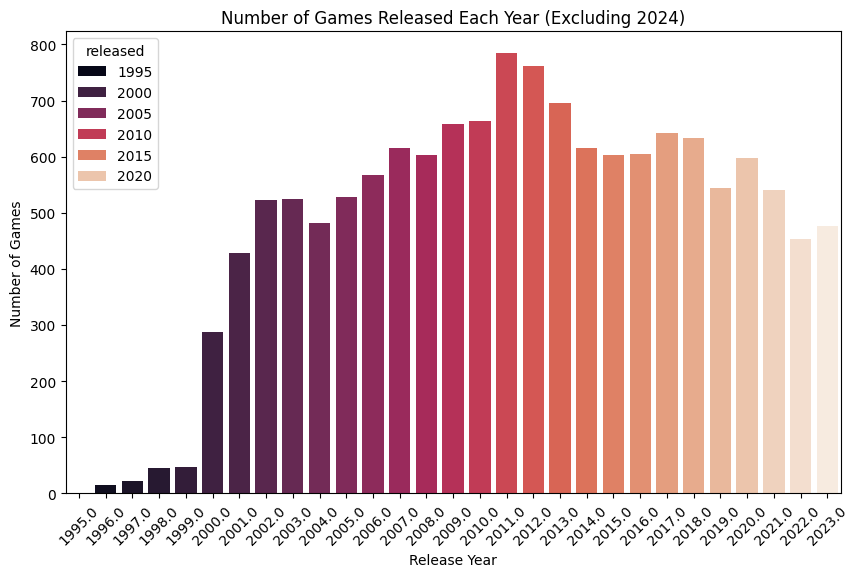

In [393]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("rocket")
sns.countplot(x=games_data[games_data['released'].dt.year != 2024]['released'].dt.year, data=games_data, palette='rocket', hue=games_data[games_data['released'].dt.year != 2024]['released'].dt.year)
plt.title('Number of Games Released Each Year (Excluding 2024)')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()

With this graph we can see which were the years with the most games and which were the years when gaming was not the most popular hobby.
We didn't take the year 2024 because there are not many games, that is because we are at the beginning of the year. (March at this moment)
An interesting observation is the growth that the games had in the interval 1999-2001.

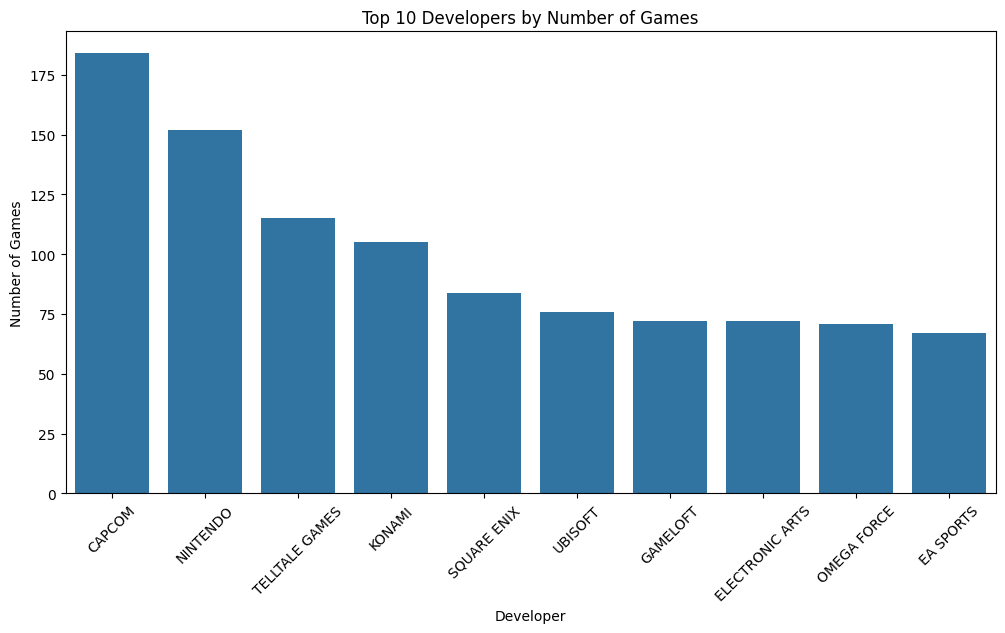

In [394]:
plt.figure(figsize=(12, 6))
sns.countplot(x='developer', data=games_data, order=games_data['developer'].value_counts().iloc[:10].index)
plt.title('Top 10 Developers by Number of Games')
plt.xlabel('Developer')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()

With this graph we can see which are the developers with more games during the last decades. 
In the first place we have Capcom, with some very popular games like Resident Evil or Street Fighters.

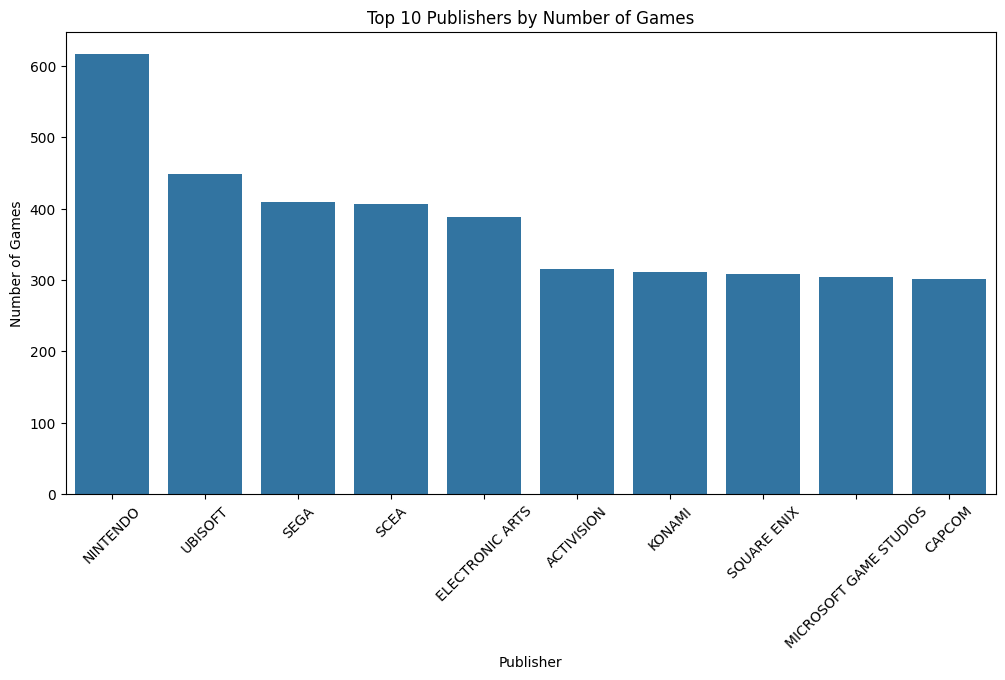

In [395]:
plt.figure(figsize=(12, 6))
sns.countplot(x='publisher', data=games_data, order=games_data['publisher'].value_counts().iloc[:10].index)
plt.title('Top 10 Publishers by Number of Games')
plt.xlabel('Publisher')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()


Here we noticed that the first pusblisher in quantity of games is Nintendo, a very well know company for their multiple famous games like Mario Bros.
We can observe more famous publishers like Ubisoft, Sega, or Activision.

### Unique values

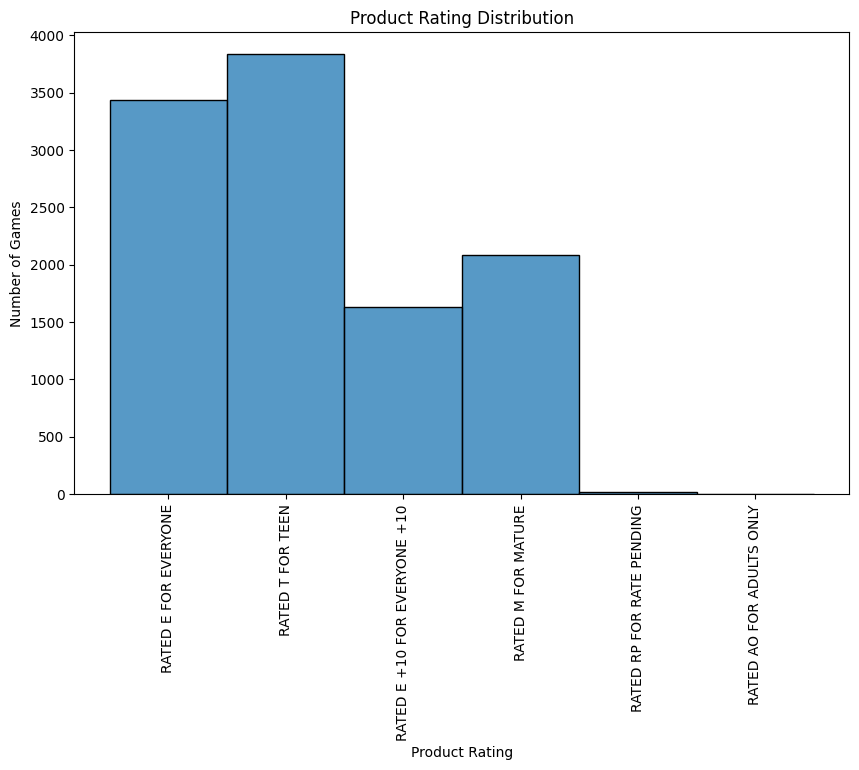

In [396]:
plt.figure(figsize=(10, 6))
sns.histplot(games_data['rating'].dropna(), kde=False, bins=20)
plt.title('Product Rating Distribution')
plt.xlabel('Product Rating')
plt.ylabel('Number of Games')
plt.xticks(rotation=90)  
plt.show()

In this graph we can observe that the most common is make games for teen people, but something interesting is the few games that are rated AO (For Adults Only), we could conclude that this is because their largest audience is teenagers, so making games for adults only would not be of much benefit to them.

# Table creation for the clean data and export to database

In [397]:
games_data.dtypes

title                    object
released         datetime64[ns]
developer                object
publisher                object
genres                   object
rating                   object
user_score              float64
ratings_count             int64
platforms                object
dtype: object

In [398]:
replacements = {
    'object': 'varchar',
    'float64': 'float',
    'int32': 'int',
    'datetime64[ns]': 'timestamp'
}
col_str = ", ".join("{} {}".format(n, d) for (n, d) in zip(games_data.columns, games_data.dtypes.replace(replacements)))
col_str

'title varchar, released timestamp, developer varchar, publisher varchar, genres varchar, rating varchar, user_score float, ratings_count int64, platforms varchar'

In [399]:
cursor.execute("DROP TABLE IF EXISTS metacritic_data;")

In [400]:
cursor.execute("CREATE TABLE IF NOT EXISTS metacritic_data (title varchar, released timestamp, developer varchar, publisher varchar, genres varchar, rating varchar, user_score float, ratings_count int, platforms varchar);")
conn.commit()

In [401]:
temp_file = StringIO()

games_data.to_csv(temp_file, sep='\t', header=False, index=False)
temp_file.seek(0)

try:
    cursor.copy_from(temp_file, 'metacritic_data', null='', sep='\t')
    conn.commit()
    print("Tabla metacritic_data creada correctamente.")
except Exception as e:
    print(f"Error al crear la tabla metacritic_data: {e}")
conn.commit()

conn.close()

Tabla metacritic_data creada correctamente.


Here we transform the changes of our df in a temp file to copy the dataset from the csv to a sql table, we did this because psycopg2 is not compatible with the to_sql function, so we decide done this way.